<a href="https://colab.research.google.com/github/jalilpablo/bike_share_scheme_predicction/blob/XGBoost/Bike_Share_Scheme_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bike Share Scheme 

## EDA

In [3]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from datetime import timedelta
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import random
import math

In [4]:
#load datasets
train = pd.read_excel('/content/bike_train.xlsx')
test = pd.read_excel('/content/bike_test.xlsx')

In [5]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


Datasets loaded correctly

In [7]:
#shape of de dataset
train.shape

(11999, 17)

In [8]:
#variables names
train.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [9]:
#count of unique values per column
train.nunique(axis=0)

instant       11999
dteday          506
season            4
yr                2
mnth             12
hr               24
holiday           2
weekday           7
workingday        2
weathersit        4
temp             48
atemp            65
hum              88
windspeed        30
casual          287
registered      623
cnt             713
dtype: int64

'instant' column has the same unique values as rows of the dataset. Looking the documentation I know it is an index so it can be not considered in our analysis.
The other counts seems to be reasonable considering the documentation.

In [10]:
#basic stadistics
train.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000,11999.000000
mean,6000.000000,2.210684,0.279523,5.530294,11.556630,0.027752,3.009334,0.684057,1.435036,0.465704,0.448888,0.625770,0.196433,30.049837,128.545129,158.594966
std,3463.957275,1.088798,0.448784,3.433005,6.911891,0.164269,2.005264,0.464910,0.650894,0.188576,0.169633,0.200637,0.125394,43.596915,124.692750,151.392952
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3000.500000,1.000000,0.000000,3.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.303000,0.470000,0.104500,3.000000,29.000000,34.000000
50%,6000.000000,2.000000,0.000000,5.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.460000,0.454500,0.620000,0.194000,13.000000,98.000000,118.000000
75%,8999.500000,3.000000,1.000000,8.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.620000,0.590900,0.790000,0.283600,39.000000,185.000000,232.000000
max,11999.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.960000,1.000000,1.000000,0.850700,367.000000,770.000000,957.000000


In [11]:
#is there any nan value, are the datatypes correct?
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

the dataset is pretty clean, there are no missing values, and all the variables are numerical. 😄

### looking into each column for outliers

#### 'dteday'

In [12]:
fig = px.box(train, y='dteday',width=700)
fig.show()

There are no outliers

#### 'Season'

In [13]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='season',width=350,height=350)
fig.show()

4 possible values, no outliers

#### 'yr'

In [14]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='yr',width=350,height=350)
fig.show()

Two possible values, no outliers

#### 'mnth'

In [15]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='mnth',width=450,height=350)
fig.show()

12 possible values, no outliers

#### 'hr'

In [16]:
#categorical data, I kwon that are 24 different values but I want to be sure that there are in the range 0-23
np.unique(train.hr, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([502, 501, 492, 477, 474, 493, 501, 503, 503, 503, 503, 503, 504,
        504, 504, 504, 505, 505, 503, 503, 503, 503, 503, 503]))

No outliers

#### 'holiday'

In [17]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='holiday',width=450,height=350)
fig.show()

no outliers

#### 'weekday'

In [18]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='weekday',width=450,height=350)
fig.show()

7 values in range 0-6, no outliers

#### 'workingday'

In [19]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='workingday',width=450,height=350)
fig.show()

no outliers

#### 'weathersit'

In [20]:
#categorical data, I use histogram to see possible values
fig = px.histogram(train, x='weathersit',width=450,height=350)
fig.show()

Four possible values, is consistent with the documentation, no outliers

#### 'temp'

In [21]:
# continuous values, I use boxplot
fig = px.box(train, y='temp',width=700)
fig.show()

normalized values between 0 and 1, no outliers

#### 'atemp'

In [22]:
# continuous values, I use boxplot
fig = px.box(train, y='atemp',width=700)
fig.show()

normalized values between 0 and 1, no outliers

#### 'hum'

In [23]:
# continuous values, I use boxplot
fig = px.box(train, y='hum',width=700)
fig.show()

normalized values between 0 and 1, no outliers

#### 'windspeed'

In [24]:
# continuous values, I use boxplot
fig = px.box(train, y='windspeed',width=700)
fig.show()

Although the boxplot shows some atipic values, there are all in the normalized range 0-1. Considering the documentation, a value of 1 represents a windspeed of 67 km/h, so this out of the box points are possible wind speed values. I think is correct to take them into account.

#### 'casual'

In [25]:
# continuous values, I use boxplot
fig = px.box(train, y='casual',width=700)
fig.show()

There are a lot of points out of the upper fence, but are all possible values of casual users count.

#### 'registered'

In [26]:
  # continuous values, I use boxplot
fig = px.box(train, y='registered',width=700)
fig.show()

There are a lot of points out of the upper fence, but are all possible values of casual users count.

#### 'cnt'

In [27]:
  # continuous values, I use boxplot
fig = px.box(train, y='cnt',width=700)
fig.show()

There are a lot of points out of the upper fence, but are all possible values of casual users count.
I will look for more information of the higher point. If it is not related to a atipical observation of the other variables, will be deleted.

In [28]:
train[train.cnt == max(train.cnt)]

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
10622,10623,2012-03-23,2,1,3,17,0,5,1,2,0.72,0.6515,0.42,0.1642,264,693,957


I think it is a correct value

### Correlations between variables

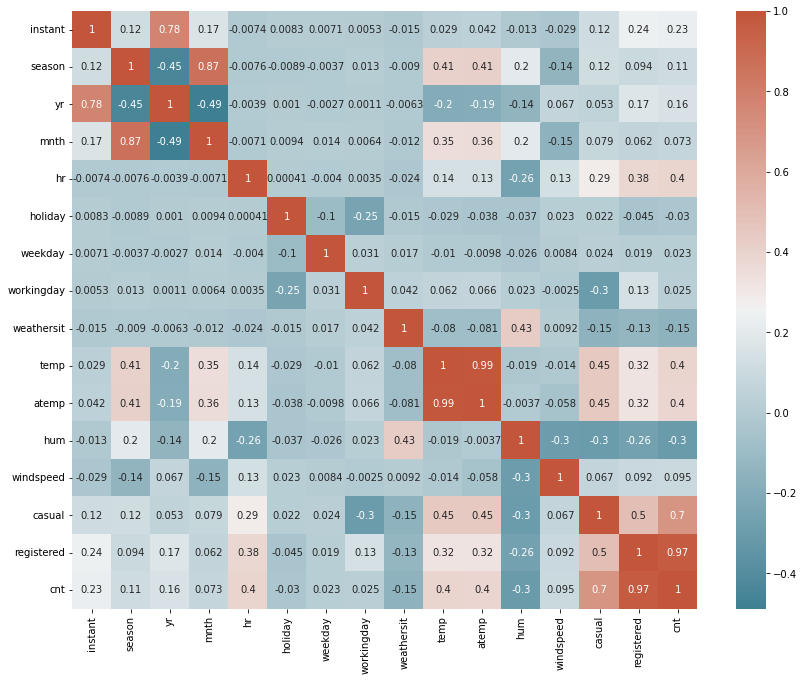

In [29]:
# calculate the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 11))

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

Very highly correlated columns:
*   'temp' - 'atemp'
*   'registered' - 'cnt'

Before continuing, I want to eliminate some columns: 'atemp' (highly correlated with 'temp'), 'instant' (an index) and 'casual' and 'registered' (both are not present in the test set and are resumed in 'cnt')



In [30]:
#deleting the columns
columns_to_be_deleted=['atemp','instant','casual','registered']
train_cleaned = train.drop(columns=columns_to_be_deleted)

In [31]:
train_cleaned.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1


## XGBoost

I will use XGBoost regressor model for this attempt

In [32]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [33]:
#splitting data into X and y
X = train_cleaned.drop(columns=['dteday','cnt']) #features, day is not relevant
y = train_cleaned['cnt'] #objetive

In [34]:
#creating pipeline
my_pipeline = Pipeline(steps=[('model',XGBRegressor())])

In [35]:
#obtaining MSE of the model
scores =-1* cross_val_score(my_pipeline, X, y,cv=5,scoring='neg_mean_squared_error')
print("MSE scores:\n", scores)

[00:48:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:48:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE scores:
 [ 5432.39552877  4466.18649503  4095.61060408  3425.8140227
 14416.56163124]


I predict using this model without hyperparameter tuning

In [36]:
#creating and fitting the model
regressor = XGBRegressor()
regressor.fit(X,y)

[00:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [37]:
#adapting test dataset to the expected format
test_xgbr = test.drop(columns=['instant','dteday','atemp'])

In [38]:
#making prediction
results = regressor.predict(test_xgbr)

In [39]:
#converting to dataframe
resultados = pd.DataFrame(data = results,columns=['pred'])

In [40]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [41]:
resultados.to_csv('jalilpablo.csv',index=False)

It has a RMSE value of 417.5410128.

In [42]:
# round instead of ceil
resultados = pd.DataFrame(data = results,columns=['pred'])

In [43]:
resultados['pred'] = resultados['pred'].apply(round)

In [44]:
resultados.to_csv('jalilpablo.csv',index=False)

It has highest RMSE

## XGBoost another model
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

In [45]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [46]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [47]:
#creating the model with the metric information
xgbr = xgb.XGBRegressor(objective='reg:squarederror')

In [48]:
xgbr.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [49]:
#making prediction
y_pred = xgbr.predict(X_test)

In [50]:
#calculating mse
mse = mean_squared_error(y_test, y_pred)

In [51]:
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 59.09


In [52]:
#creating model and training with the full dataset
xgbr = xgb.XGBRegressor(objective='reg:squarederror')
xgbr.fit(X,y)
resultados = xgbr.predict(X_test)


In [53]:
# results to dataframe
resultados = pd.DataFrame(data = resultados,columns=['pred'])

In [54]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [55]:
#is any negative value
sum(resultados['pred']<0)

117

In [56]:
#transform negative to 0
for i in range(len(resultados['pred'])):
  if resultados['pred'][i]<0:
    resultados['pred'][i]=0

In [57]:
resultados.to_csv('jalilpablo.csv',index=False)

## XGBoost hyperparameter tuning

In [58]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: ignored

In [ ]:
#training the model with the complete dataset and best parameters
xgbr = xgb.XGBRegressor(subsample=0.8999999999999999,
                        n_estimators= 500,
                        max_depth= 6,
                        learning_rate=0.1,
                        colsample_bytree= 0.6,
                        colsample_bylevel=0.6)
xgbr.fit(X,y)

In [ ]:
#making prediction
results = xgbr.predict(test_xgbr)

In [ ]:
# results to dataframe
resultados = pd.DataFrame(data = results,columns=['pred'])

In [ ]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [ ]:
#is any negative value
sum(resultados['pred']<0)

In [ ]:
#transform negative to 0
for i in range(len(resultados['pred'])):
  if resultados['pred'][i]<0:
    resultados['pred'][i]=0

In [ ]:
#dowload
resultados.to_csv('jalilpablo.csv',index=False)

### simplified grid search

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [ ]:
#training the model with the complete dataset and best parameters
xgbr = xgb.XGBRegressor(subsample=0.8999999999999999,
                        n_estimators= 1000,
                        max_depth= 6,
                        learning_rate=0.1,
                        colsample_bytree= 0.3,
                        colsample_bylevel=0.6)
xgbr.fit(X,y)

In [ ]:
#making prediction
results = xgbr.predict(test_xgbr)

In [ ]:
# results to dataframe
resultados = pd.DataFrame(data = results,columns=['pred'])

In [ ]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [ ]:
#is any negative value
sum(resultados['pred']<0)

In [ ]:
#transform negative to 0
for i in range(len(resultados['pred'])):
  if resultados['pred'][i]<0:
    resultados['pred'][i]=0

In [ ]:
#dowload
resultados.to_csv('jalilpablo.csv',index=False)

it seems the model is overfitted, I will change the hyperparameters

In [ ]:
#prevent overfitting
xgbr = xgb.XGBRegressor(subsample=0.7,
                        n_estimators= 1000,
                        max_depth= 6,
                        learning_rate=0.1,
                        colsample_bytree= 0.2,
                        colsample_bylevel=0.6)
xgbr.fit(X,y)

In [ ]:
#making prediction
results = xgbr.predict(test_xgbr)

In [ ]:
# results to dataframe
resultados = pd.DataFrame(data = results,columns=['pred'])

In [ ]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [ ]:
#is any negative value
sum(resultados['pred']<0)

In [ ]:
#transform negative to 0
for i in range(len(resultados['pred'])):
  if resultados['pred'][i]<0:
    resultados['pred'][i]=0

In [ ]:
#dowload
resultados.to_csv('jalilpablo.csv',index=False)

It is the best RMSE so far 229.4525973

I will continue preventing overfitting

In [59]:
#prevent overfitting
xgbr = xgb.XGBRegressor(subsample=0.6,
                        n_estimators= 1000,
                        max_depth= 5,
                        learning_rate=0.1,
                        colsample_bytree= 0.2,
                        colsample_bylevel=0.6)
xgbr.fit(X,y)

[00:49:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.6, colsample_bytree=0.2, max_depth=5,
             n_estimators=1000, subsample=0.6)

In [60]:
#making prediction
results = xgbr.predict(test_xgbr)

In [75]:
# results to dataframe
resultados = pd.DataFrame(data = results,columns=['pred'])

In [76]:
#ceiling
resultados['pred'] = resultados['pred'].apply(math.ceil)

In [77]:
#is any negative value
sum(resultados['pred']<1)

26

In [69]:
#wich is the minimun value of y?
min(y)

1

In [70]:
#transform negative and 0 to 1
for i in range(len(resultados['pred'])):
  if resultados['pred'][i]<1:
    resultados['pred'][i]=1

In [72]:
#dowload
resultados.to_csv('jalilpablo.csv',index=False)